In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
from astropy.io import ascii

%matplotlib inline

## Definitions of fields can be found at:
### confirmed planets:
https://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html
### KOIs:
https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

In [2]:
KOIs = ascii.read("../../../../KOIs_chen2018_goodSystems.csv")
print(KOIs)
print(len(KOIs.colnames))
print(KOIs.colnames)

 kepid   kepoi_name  kepler_name  ...   koi_pmass_err1     koi_pmass_err2  
-------- ---------- ------------- ... ------------------ ------------------
 1026957  K00958.01            -- ...  5.769464972554899  3.244408578305821
 1161345  K00984.01            -- ...  6.326092545818279 3.5574232654922424
 1429589  K04923.01            -- ... 1.5735103860765358 0.7378008287493754
 1431122  K00994.01            -- ...  2.419108737036141 1.0891220900035181
 1432789  K00992.01  Kepler-745 b ...  5.964185807741979  3.027858259246558
 1432789  K00992.02            -- ...  2.437079035986733 1.0697247065679856
 1717722  K03145.01            -- ... 2.6787928971009194 1.3399128949332408
 1717722  K03145.02            -- ... 1.3217080679402717 0.6511151044108447
 1718189  K00993.03            -- ... 3.0588005877402042 1.4588377614817154
 1718189  K00993.02  Kepler-262 b ... 2.9891737858212397  1.378072373671277
     ...        ...           ... ...                ...                ...
12645057  K0

In [3]:
print(len(np.array(KOIs['kepid'])))
print(len(np.unique(np.array(KOIs['kepid']))))

print(len(np.array(KOIs['koi_prad'])[~np.isnan(KOIs["koi_prad"])]))
print(len(np.array(KOIs['koi_ror'])[~np.isnan(KOIs["koi_ror"])]))
print(len(np.array(KOIs['koi_insol'])[~np.isnan(KOIs["koi_insol"])]))

3512
2656
3512
3512
3512


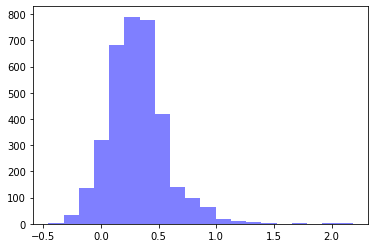

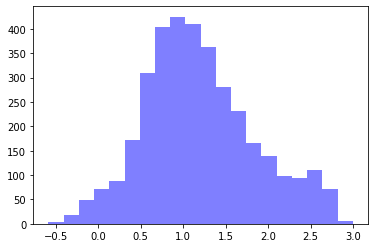

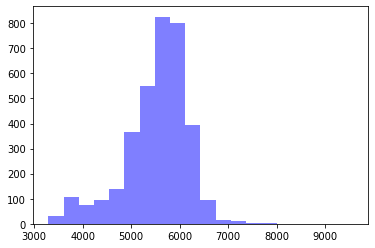

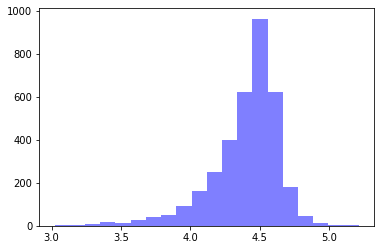

0.132
2.697


In [4]:
plt.hist(np.log10(KOIs['koi_prad']),bins=20,color='b',alpha=0.5)
plt.show()


plt.hist(np.log10(KOIs['koi_period']),bins=20,color='b',alpha=0.5)
plt.show()


plt.hist(KOIs['koi_steff'],bins=20,color='b',alpha=0.5)
plt.show()


plt.hist(KOIs['koi_slogg'],bins=20,color='b',alpha=0.5)
plt.show()


print(np.min(KOIs['koi_smass']))
print(np.max(KOIs['koi_smass']))

## Want these in a format:
### each row = 1 planetary system, i.e. a list of "planets"
### each "planet" = an array of [Rp/Rstar, P, Teff, logg, Fe/H]

In [5]:
systems = []

idxs = np.arange(len(KOIs['kepid']))
kepids = np.array(KOIs['kepid'])
unique_kepid = np.unique(np.array(KOIs['kepid']))
print(len(unique_kepid))

# Impose feature scaling!
Teff_mean = np.mean(KOIs['koi_steff'])
logg_mean = np.mean(KOIs['koi_slogg'])
#met_mean = np.mean(KOIs['koi_smet'])

rad_mean = np.mean(np.log10(KOIs['koi_prad']))
#rad_mean = np.mean(KOIs['koi_prad'])
#rad_mean = np.mean(KOIs['koi_ror'])

period_mean = np.mean(np.log10(KOIs['koi_period']))
#period_mean = np.mean(KOIs['koi_period'])

#insol_mean = np.mean(KOIs['koi_insol'])

Teff_sigma = np.std(KOIs['koi_steff'])
logg_sigma = np.std(KOIs['koi_slogg'])
#met_sigma = np.std(KOIs['koi_smet'])
rad_sigma = np.std(np.log10(KOIs['koi_prad']))
#rad_sigma = np.std(KOIs['koi_prad'])
#rad_sigma = np.std(KOIs['koi_ror'])

period_sigma = np.std(np.log10(KOIs['koi_period']))
#period_sigma = np.std(KOIs['koi_period'])

#insol_sigma = np.std(KOIs['koi_insol'])


print("means:")
#print(rad_mean,period_mean,insol_mean,Teff_mean,logg_mean,met_mean)
print(rad_mean,period_mean,Teff_mean,logg_mean)
print("sigmas:")
#print(rad_sigma,period_sigma,insol_sigma,Teff_sigma,logg_sigma,met_sigma)
print(rad_sigma,period_sigma,Teff_sigma,logg_sigma)

for ID in unique_kepid:
    goodSystem = True
    system = []
    thisSystem_mask = (kepids == ID)
    thisSystem_idxs = idxs[thisSystem_mask]
    
    #singles only
    #if len(thisSystem_idxs) > 1:
    #all systems
    if True:
        kepNames = KOIs['kepoi_name'][thisSystem_idxs]
        Ps = KOIs['koi_period'][thisSystem_idxs]
        #sort KOIs from inner to outer
        sort = np.argsort(Ps)
        thisSystem_idxs = thisSystem_idxs[sort]

        count = KOIs['koi_count'][thisSystem_idxs[0]]

        Teff = KOIs['koi_steff'][thisSystem_idxs[0]]
        logg = KOIs['koi_slogg'][thisSystem_idxs[0]]
        met = KOIs['koi_smet'][thisSystem_idxs[0]]

        if np.any(np.isnan(np.array((Teff,logg,met)))):
            print(np.array((Teff,logg,met)))
            print("star nan!")
            print(ID)
            pass

        else:
            for j in range(1,count+1):
                planet = []
                planet.append( (np.log10(KOIs['koi_prad'][thisSystem_idxs[j-1]]) - rad_mean)/rad_sigma )
                planet.append( (np.log10(KOIs['koi_period'][thisSystem_idxs[j-1]]) - period_mean)/period_sigma )
                #planet.append( ((KOIs['koi_insol'][thisSystem_idxs[j-1]]) - insol_mean)/insol_sigma )
                
                planet.append( (Teff-Teff_mean)/Teff_sigma )
                planet.append( (logg-logg_mean)/logg_sigma )
                #planet.append( (met-met_mean)/met_sigma )
                if np.any(np.isnan(np.array((planet)))):
                    print(planet)
                    print("planet nan!")
                    print(ID)
                    goodSystem = False
                    pass
                else:
                    system.append((planet))

            if goodSystem is True:
                systems.append(system)

print(len(systems))

print(type(systems))
print(type(systems[0]))
print(type(systems[0][0]))

with open("realKOIs_allFeatures.txt", "wb") as picklefile:
    pickle.dump(systems, picklefile)

2656
means:
0.315288527240129 1.1956284811335791 5532.606492027335 4.396738325740319
sigmas:
0.2567266294591877 0.6511098008677794 660.621410145989 0.2503844154525694
2656
<class 'list'>
<class 'list'>
<class 'list'>


In [6]:
with open("realKOIs_allFeatures.txt", "rb") as picklefile:
    systest = pickle.load(picklefile)

print(len(systest))
print(type(systest))
print(type(systest[0]))
print(type(systest[0][0]))
print(systest[0:2])
print(systems[0:2])

2656
<class 'list'>
<class 'list'>
<class 'list'>
[[[0.342122646648355, 0.21817567069433336, -1.0196558598948167, 0.8597247311522795]], [[0.17351902758821786, -0.8653344219876473, -0.3581574687006401, 0.7159458145015346]]]
[[[0.342122646648355, 0.21817567069433336, -1.0196558598948167, 0.8597247311522795]], [[0.17351902758821786, -0.8653344219876473, -0.3581574687006401, 0.7159458145015346]]]


# Divide into 70% training, 30% test data

In [7]:
systems = []

idxs = np.arange(len(KOIs['kepid']))
kepids = np.array(KOIs['kepid'])
unique_kepid = np.unique(np.array(KOIs['kepid']))
print(len(unique_kepid))

np.random.seed(42)
np.random.shuffle(unique_kepid)

unique_kepid_70 = unique_kepid[:int(0.7*len(unique_kepid))]
unique_kepid_30 = unique_kepid[int(0.7*len(unique_kepid)):]

print(len(unique_kepid_70))
print(len(unique_kepid_30))


print("means:")
#print(rad_mean,period_mean,insol_mean,Teff_mean,logg_mean,met_mean)
print(rad_mean,period_mean,Teff_mean,logg_mean)
print("sigmas:")
#print(rad_sigma,period_sigma,insol_sigma,Teff_sigma,logg_sigma,met_sigma)
print(rad_sigma,period_sigma,Teff_sigma,logg_sigma)

for ID in unique_kepid_70:
    goodSystem = True
    system = []
    thisSystem_mask = (kepids == ID)
    thisSystem_idxs = idxs[thisSystem_mask]
    
    #singles only
    #if len(thisSystem_idxs) > 1:
    #all systems
    if True:
        kepNames = KOIs['kepoi_name'][thisSystem_idxs]
        Ps = KOIs['koi_period'][thisSystem_idxs]
        #sort KOIs from inner to outer
        sort = np.argsort(Ps)
        thisSystem_idxs = thisSystem_idxs[sort]

        count = KOIs['koi_count'][thisSystem_idxs[0]]

        Teff = KOIs['koi_steff'][thisSystem_idxs[0]]
        logg = KOIs['koi_slogg'][thisSystem_idxs[0]]
        met = KOIs['koi_smet'][thisSystem_idxs[0]]

        if np.any(np.isnan(np.array((Teff,logg,met)))):
            print(np.array((Teff,logg,met)))
            print("star nan!")
            print(ID)
            pass

        else:
            for j in range(1,count+1):
                planet = []
                planet.append( (np.log10(KOIs['koi_prad'][thisSystem_idxs[j-1]]) - rad_mean)/rad_sigma )
                planet.append( (np.log10(KOIs['koi_period'][thisSystem_idxs[j-1]]) - period_mean)/period_sigma )
                #planet.append( ((KOIs['koi_insol'][thisSystem_idxs[j-1]]) - insol_mean)/insol_sigma )
                
                planet.append( (Teff-Teff_mean)/Teff_sigma )
                planet.append( (logg-logg_mean)/logg_sigma )
                #planet.append( (met-met_mean)/met_sigma )
                if np.any(np.isnan(np.array((planet)))):
                    print(planet)
                    print("planet nan!")
                    print(ID)
                    goodSystem = False
                    pass
                else:
                    system.append((planet))

            if goodSystem is True:
                systems.append(system)

print(len(systems))
with open("realKOIs_allFeatures_70percent.txt", "wb") as picklefile:
    pickle.dump(systems, picklefile)
    
systems = []   
for ID in unique_kepid_30:
    goodSystem = True
    system = []
    thisSystem_mask = (kepids == ID)
    thisSystem_idxs = idxs[thisSystem_mask]
    
    #singles only
    #if len(thisSystem_idxs) > 1:
    #all systems
    if True:
        kepNames = KOIs['kepoi_name'][thisSystem_idxs]
        Ps = KOIs['koi_period'][thisSystem_idxs]
        #sort KOIs from inner to outer
        sort = np.argsort(Ps)
        thisSystem_idxs = thisSystem_idxs[sort]

        count = KOIs['koi_count'][thisSystem_idxs[0]]

        Teff = KOIs['koi_steff'][thisSystem_idxs[0]]
        logg = KOIs['koi_slogg'][thisSystem_idxs[0]]
        met = KOIs['koi_smet'][thisSystem_idxs[0]]

        if np.any(np.isnan(np.array((Teff,logg,met)))):
            print(np.array((Teff,logg,met)))
            print("star nan!")
            print(ID)
            pass

        else:
            for j in range(1,count+1):
                planet = []
                planet.append( (np.log10(KOIs['koi_prad'][thisSystem_idxs[j-1]]) - rad_mean)/rad_sigma )
                planet.append( (np.log10(KOIs['koi_period'][thisSystem_idxs[j-1]]) - period_mean)/period_sigma )
                #planet.append( ((KOIs['koi_insol'][thisSystem_idxs[j-1]]) - insol_mean)/insol_sigma )
                
                planet.append( (Teff-Teff_mean)/Teff_sigma )
                planet.append( (logg-logg_mean)/logg_sigma )
                #planet.append( (met-met_mean)/met_sigma )
                if np.any(np.isnan(np.array((planet)))):
                    print(planet)
                    print("planet nan!")
                    print(ID)
                    goodSystem = False
                    pass
                else:
                    system.append((planet))

            if goodSystem is True:
                systems.append(system)
print(len(systems))
with open("realKOIs_allFeatures_30percent.txt", "wb") as picklefile:
    pickle.dump(systems, picklefile)

2656
1859
797
means:
0.315288527240129 1.1956284811335791 5532.606492027335 4.396738325740319
sigmas:
0.2567266294591877 0.6511098008677794 660.621410145989 0.2503844154525694
1859
797


## Bootstrapped versions of training set

In [8]:
"""
idxs = np.arange(len(KOIs['kepid']))
kepids = np.array(KOIs['kepid'])
unique_kepid = np.unique(np.array(KOIs['kepid']))
print(len(unique_kepid))

np.random.seed(42)
np.random.shuffle(unique_kepid)

unique_kepid_70 = unique_kepid[:int(0.7*len(unique_kepid))]
#unique_kepid_30 = unique_kepid[int(0.7*len(unique_kepid)):]

print(len(unique_kepid_70))


print("means:")
#print(rad_mean,period_mean,insol_mean,Teff_mean,logg_mean,met_mean)
print(rad_mean,period_mean,Teff_mean,logg_mean)
print("sigmas:")
#print(rad_sigma,period_sigma,insol_sigma,Teff_sigma,logg_sigma,met_sigma)
print(rad_sigma,period_sigma,Teff_sigma,logg_sigma)

for b in range(100):
    systems = []

    bootstrapped_kepid_70 = np.random.choice(unique_kepid_70,size=len(unique_kepid_70),replace=True)

    for ID in bootstrapped_kepid_70:
        goodSystem = True
        system = []
        thisSystem_mask = (kepids == ID)
        thisSystem_idxs = idxs[thisSystem_mask]

        #singles only
        #if len(thisSystem_idxs) > 1:
        #all systems
        if True:
            kepNames = KOIs['kepoi_name'][thisSystem_idxs]
            Ps = KOIs['koi_period'][thisSystem_idxs]
            #sort KOIs from inner to outer
            sort = np.argsort(Ps)
            thisSystem_idxs = thisSystem_idxs[sort]

            count = KOIs['koi_count'][thisSystem_idxs[0]]

            Teff = KOIs['koi_steff'][thisSystem_idxs[0]]
            logg = KOIs['koi_slogg'][thisSystem_idxs[0]]
            met = KOIs['koi_smet'][thisSystem_idxs[0]]

            if np.any(np.isnan(np.array((Teff,logg,met)))):
                print(np.array((Teff,logg,met)))
                print("star nan!")
                print(ID)
                pass

            else:
                for j in range(1,count+1):
                    planet = []
                    planet.append( ((KOIs['koi_prad'][thisSystem_idxs[j-1]]) - rad_mean)/rad_sigma )
                    planet.append( ((KOIs['koi_period'][thisSystem_idxs[j-1]]) - period_mean)/period_sigma )
                    #planet.append( ((KOIs['koi_insol'][thisSystem_idxs[j-1]]) - insol_mean)/insol_sigma )

                    planet.append( (Teff-Teff_mean)/Teff_sigma )
                    planet.append( (logg-logg_mean)/logg_sigma )
                    #planet.append( (met-met_mean)/met_sigma )
                    if np.any(np.isnan(np.array((planet)))):
                        print(planet)
                        print("planet nan!")
                        print(ID)
                        goodSystem = False
                        pass
                    else:
                        system.append((planet))

                if goodSystem is True:
                    systems.append(system)

    print(len(systems))
    with open("realKOIs_allFeatures_70percent_bootstrap{0}.txt".format(b), "wb") as picklefile:
        pickle.dump(systems, picklefile)
"""

'\nidxs = np.arange(len(KOIs[\'kepid\']))\nkepids = np.array(KOIs[\'kepid\'])\nunique_kepid = np.unique(np.array(KOIs[\'kepid\']))\nprint(len(unique_kepid))\n\nnp.random.seed(42)\nnp.random.shuffle(unique_kepid)\n\nunique_kepid_70 = unique_kepid[:int(0.7*len(unique_kepid))]\n#unique_kepid_30 = unique_kepid[int(0.7*len(unique_kepid)):]\n\nprint(len(unique_kepid_70))\n\n\nprint("means:")\n#print(rad_mean,period_mean,insol_mean,Teff_mean,logg_mean,met_mean)\nprint(rad_mean,period_mean,Teff_mean,logg_mean)\nprint("sigmas:")\n#print(rad_sigma,period_sigma,insol_sigma,Teff_sigma,logg_sigma,met_sigma)\nprint(rad_sigma,period_sigma,Teff_sigma,logg_sigma)\n\nfor b in range(100):\n    systems = []\n\n    bootstrapped_kepid_70 = np.random.choice(unique_kepid_70,size=len(unique_kepid_70),replace=True)\n\n    for ID in bootstrapped_kepid_70:\n        goodSystem = True\n        system = []\n        thisSystem_mask = (kepids == ID)\n        thisSystem_idxs = idxs[thisSystem_mask]\n\n        #singles 

In [9]:
print(2079 + 2*384 + 3*129 + 4*44 + 5*18 + 6*2)

3512


In [10]:
print(2079+384+129+44+18+2)

2656
